# TOF data
Data taken at intervals of $T=0.1ms$, where $T$ represents the period of free flight after trapping. Captured in sequences of 10 ranging from 0.1ms to 1.0ms. 

In [192]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [ ]:
DATA_DIR = Path("/home/ben/Desktop/MOT_BRW/mar02/")

#count from .1 to 1.0 in intervals of 1 and then start over
time_data = list(zip(*product(range(10), np.linspace(.1,1,10))))[1]
data = []

for i,time in enumerate(time_data):
    print(i, time)
    data.append(
        DataRun(11+i, time, 20, 4, .4)
    )

In [183]:
class DataRun:
    def __init__(self, num, time, filter_median, image_median, box_scale, min_pixels = 10000):
        self.num = num
        self.time = time
        self.median_filter = filter_median
        self.median_image = image_median
        self.box_scale = box_scale

        self.images()
        self.load()
        threshhold = .5
        while self.mask(threshhold) < min_pixels:
            threshhold -= .05

        #extract blob rectangle from image
        self.blob_image = self.od_arr[self.box[0]:self.box[3], self.box[0]:self.box[2]]
        #apply a median filter
        self.blob_image = median_filter(self.blob_image, self.median_image)

        self.fit()

    def incircle(self, center, radius, pt):
            return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

    def images(self):
        images =  [imread(DATA_DIR / f"image_{self.num}_{i}.tif") for i in range(4)]

        im0 = images[0]
        im0_background = images[2]
        im1 = images[1]
        im1_background = images[3]

        I0_arr=np.subtract(np.array(im0),
                            np.array(im0_background)).astype(int)
        I_arr=np.subtract(np.array(im1),
                            np.array(im1_background)).astype(int)

        return I_arr, I0_arr

    def grow_box(self,box, factor):
        width = box[3]-box[1]
        height = box[2]-box[0]
        x1 = round(box[1] - width*factor)
        y1 = round(box[0] - height*factor)
        x2 = round(box[3] + width*factor)
        y2 = round(box[2] + height*factor)
        return (x1,y1,x2,y2)

    def load(self):

        I_arr, I0_arr = self.images()

        I_div_arr = np.divide(I_arr, I0_arr)
        od_arr = np.log(I_div_arr)

        #first pass, just clip anything not within the aperture
        for i,row in enumerate(od_arr):
            for j, pixel in enumerate(row):
                if pixel < 0 or not self.incircle((600,600),300,(i,j)):
                    od_arr[i][j] = 0

        self.od_arr = od_arr

    def mask(self, threshhold):
        value_mask = self.od_arr[:,:] > threshhold
        self.mask_filtered = median_filter(value_mask, self.median_filter)

        blobs = label(self.mask_filtered)
        props = regionprops(blobs) #generate a properties dictionary

        if not props:
            return 0
            
        bbox = props[0].bbox #get the bounding box

        self.box = self.grow_box(bbox, self.box_scale)

        return props[0].num_pixels

    def gaussian_fit(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def fit(self):
        #compute marginals and fit to a gaussian

        x, y = margins(self.blob_image)
        x = x.T[0]
        y = y[0]

        self.popt_x, self.pcov_x = curve_fit(self.gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
        self.popt_y, self.pcov_y = curve_fit(self.gaussian_fit, np.arange(len(y)), y, [350,150,60])

        self.x = x
        self.y = y

    def plot_box(self):
        #draw bounding box
        fig, ax = plt.subplots()
        rect = plt.Rectangle((self.box[0], self.box[1]), self.box[2]-self.box[0], self.box[3]-self.box[1])
        rect.set(fill=False, color = "red")
        ax.add_artist(rect)
        ax.imshow(self.od_arr)

    def plot_blob(self):
        plt.imshow(self.mask_filtered)

    def plot_fit(self):

        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1,0])
        ax.imshow(self.blob_image)

        #axes are flipped!!
        ax_y = fig.add_subplot(gs[0,0], sharex=ax)
        ax_x = fig.add_subplot(gs[1,1], sharey=ax)

        ax_y.plot(self.y)
        ax_y.plot(np.arange(len(self.y)), self.gaussian_fit(np.arange(len(self.y)),*self.popt_y))

        ax_x.plot(self.x, np.arange(len(self.x)))
        ax_x.plot(self.gaussian_fit(np.arange(len(self.x)),*self.popt_x),np.arange(len(self.x)))

        ax.errorbar(self.popt_y[1], self.popt_x[1], xerr = np.abs(self.popt_y[2]), yerr = np.abs(self.popt_x[2]), color = 'r', marker = "x", capsize = 10)

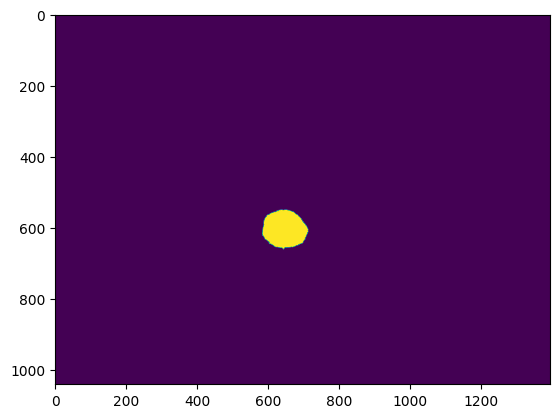

In [199]:
data[0].plot_blob()

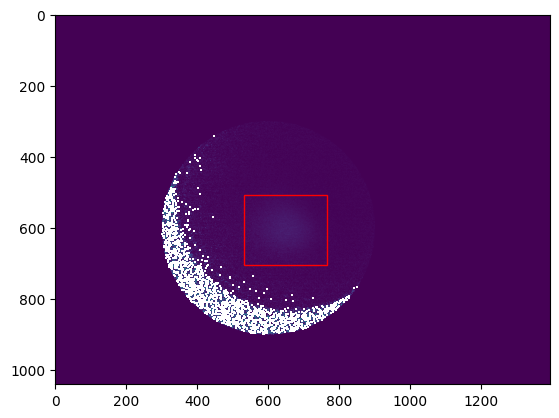

In [200]:
data[0].plot_box()

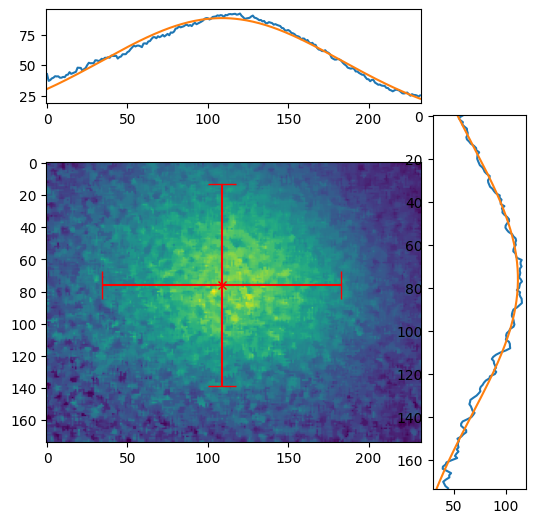

In [201]:
data[0].plot_fit()

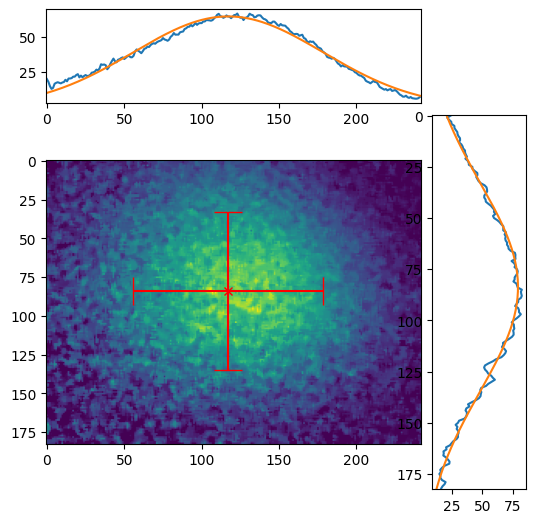

In [206]:
data[50].plot_fit()

In [203]:
data[50].time

0.1